# Credit Card Fraud Detection: Analysis and Prevention

In today’s digital world, credit card fraud is a real worry for everyone. This analysis looks at patterns in credit card transactions to find helpful insights that can make spotting fraud easier and keep customers safer.

With a clearer picture of transaction patterns, businesses can catch fraud more quickly and avoid unnecessary costs. 

Better fraud detection means fewer chargebacks and a smoother experience for customers, helping to keep things running smoothly while protecting everyone involved.

## The Dataset

The dataset, sourced from Kaggle, captures credit card transactions by cardholders across various U.S. states. Key features include:

- **TransactionID:** 

  Unique identifier for each transaction, enabling easy traceability.

- **TransactionDate:** 

  Date and time of the transaction, facilitating time based trends.

- **Amount:** 

  Transaction amount. We can use this for identifying fraudulent transaction patterns by amount.

- **MerchantID:** 

  Unique identifier for the merchant where the transaction occurred. Aids in detecting merchant-specific fraud.

- **TransactionType:** 

  Type of transaction, either 'purchase' or 'refund.'

- **Location:** 

  U.S. city or state where the transaction took place, providing insights into regional fraud trends.

- **IsFraud:** 

  Indicator of fraudulent (1) or legitimate (0) transactions, serving as the target feature for training the fraud detection model.


The dataset includes 100,100 transactions, with a small percentage flagged as fraudulent.

## Analysis Objectives:

#### Exploratory Data Analysis:

- Find out the distribution of transactions, amounts, and types of transactions.
- Identify patterns in dates of transaction and locations.
- How many transactions are fraudulent?

#### Identify trends:

- Group transactions and identify unusual trends.
- Identify relationships between transaction attributes - like location, amount of transaction, and fraud.

#### Detection

- Apply a learning model to predict transactions as fraud or legitimate.
- Review the learning model and see if it performs well in predicting fraud.

#### Identify Important attributes of a credit card transaction

- Determine which attribute - like location, merchant, contributes better to the detection of fraudulent transactions.

#### Recommended Solutions

- Real-Time monitoring system. Develop a system, or service that can analyze a transaction in real-time and flag the transaction based on the learned patterns.

- Provide enhanced security and verification systems for merchants and providers.

- Ensure compliance to regulations and security standards, such as PCI-DSS, and strengthen security protocols of payment systems.



Addressing credit card fraud is important for preserving consumer confidence and ensures the stability of the payment systems. 

This analysis uses scientific methods and advanced data learning techniques to identify effective solutions for eliminating credit card fraud.

## Import Required Python Libraries

In [243]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Load the Credit Card Dataset

In [244]:
cc_df = pd.read_csv('credit_card_fraud_dataset.csv')

## Data Overview

Let's view the first 5 records from the dataset and see if the column names and details coincides with the information we got from the source of the data.

In [245]:
cc_df.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


All column names are named as described, along with a sample of it's corresponding values.
We see that There is a mix of numeric and string values, including a date column. 

We might need to transform some of the dtypes of these column values to suit the requirements for the next steps. That is:

- String values are considered Categorical - i.e: Nominal, not-ordinal, or non-numeric. Categorical variables need to be converted to numeric (ordinal values) in order to allow for statistical or algorithmic analysis.

- Numeric values, as indicated may need to be transformed to its actual numeric type.

- As for the column **IsFraud**, we have to make sure it is in it's binary numeric form.

Let's use the pandas' info() method to inspect the data type of the columns,

### Feature Data Types

In [246]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


As you can see, the number types are actually set to its pandas' recognized dtypes:

- Amount is in float as it requires decimal notation for the cents component.
- IsFraud is set at int64, but we expect it to only have either 0 or 1 in each row as the boolean equivalent of False and True.
- TransactionDate is already in the pandas recognized format, which is datetime.

Now let's further inspect the numeric types and see if we find anything out of place. Let' use pandas' describe() method to do this,

In [247]:
cc_df.describe()

,TransactionID,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,2497.092666,501.676070,0.010000
std,28867.657797,1442.415999,288.715868,0.099499
min,1.000000,1.050000,1.000000,0.000000
25%,25000.750000,1247.955000,252.000000,0.000000
50%,50000.500000,2496.500000,503.000000,0.000000
75%,75000.250000,3743.592500,753.000000,0.000000
max,100000.000000,4999.770000,1000.000000,1.000000


- IsFraud is truly a numeric boolean as the min and max shows 0 and 1 respectively, and no other values in between.

All other columns looks good.

Now let's check if we having missing data,

### Missing Values

In [248]:
cc_df.isnull().sum()

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

There is no missing values in any of the columns.

### Check Relationships

We need to check the relationships of each feature in the data against the target **IsFraud**. Stronger relationships means a feature has a greater influence on the predictability of the learning system.

For numeric features, we use pandas' corr() method to get the correlation between a given feature and the target.
For categorical feautures, we use Cramer's V rule.

In the next steps, we calculate the numeric and categorical relationship scores of each feature, then create a table to show the scores by feature.

In [249]:
from scipy.stats import chi2_contingency

# List the features and set a variable for target
target = 'IsFraud'
features_numeric = cc_df.select_dtypes(include=['number']).columns

# numeric features list
features_numeric

Index(['TransactionID', 'Amount', 'MerchantID', 'IsFraud'], dtype='object')

Now, let's calculate the numeric feature correlations to the target, **IsFraud**

In [250]:
from scipy.stats import chi2_contingency

target = 'IsFraud'
features_numeric = cc_df.select_dtypes(include=['number']).columns

# Get correlation of numeric features
#

correlations_numeric = cc_df[features_numeric].corr()[target].sort_values(ascending=False).drop(labels=target)

# Convert to DataFrame for better visualization
correlation_df = pd.DataFrame(correlations_numeric).reset_index()
correlation_df.columns = ['Feature', 'corr']

# Display the correlation DataFrame
print(correlation_df)

         Feature      corr
0         Amount  0.001399
1     MerchantID  0.001157
2  TransactionID -0.000209


The feature 'Amount' shows the strongest correlation, but not a strong enough relationship to the target.

Now let's compute the correlations of the categorical features,

In [251]:
# Get correlation of categorical features to the target

features_cat = cc_df.drop(columns=target).select_dtypes(include=['object']).columns
# Method to compute Cramer's V for categoricals
def cramers_v(X, y):
  conf_matrix = pd.crosstab(X, y)
  chi2 = chi2_contingency(conf_matrix)[0]
  n = conf_matrix.sum().sum()
  phi2 = chi2 / n
  r, k = conf_matrix.shape

  return np.sqrt(phi2 / min(k-1, r-1))

categorical_rel = {}

target_df = cc_df[target]
for feature in features_cat:
  if cc_df[feature].dtype == 'object':
    cv = cramers_v(cc_df[feature], target_df)
    categorical_rel[feature] = cv

cat_rel_df = pd.DataFrame(list(categorical_rel.items()), columns=['Feature', 'cramers_v'])

relationship_map = pd.merge(correlation_df, cat_rel_df, on='Feature', how='outer')

display(relationship_map)


,Feature,corr,cramers_v
0,Amount,0.001399,NaN
1,Location,NaN,0.008699
2,MerchantID,0.001157,NaN
3,TransactionDate,NaN,1.000000
4,TransactionID,-0.000209,NaN
5,TransactionType,NaN,0.001043


: 

The table above shows both the numeric and catgorical relationship values.

It appears the categorical relationships - in the cramers_v column, shows that **Location** has the strongest relation to the target, but, again not as strong a relationship to influence the decisions that arrived at the value set in **IsFraud**.

## Visualization

Let's see the relationship of the features to one another find out if there are any strong dependencies.

In [ ]:
numerical_cols = cc_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = cc_df.select_dtypes(include=['object']).columns.tolist()

encoded_df = pd.get_dummies(cc_df, columns=categorical_cols, drop_first=True)
# Get numeric corr()s
corr = encoded_df.corr()

# Plot correlations
plt.figure(figsize=(10, 6))
sns.heatmap(corr.astype(float), annot=True, fmt=".2f", cmap='coolwarm')
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()


The locations have equal correlations on each other - a weak one at that, but not more strong correlations anywhere else.

### Fraudulent Transaction Distribution

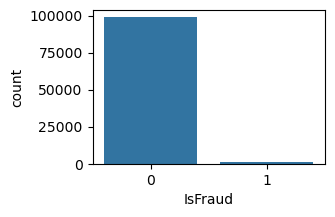

      Card transactions: 100000
Fraudulent transactions: 1000 (1.0%)


In [47]:
# Plot distribution of fraud vs legitimate transactions
plt.figure(figsize=(3, 2))
sns.countplot(x='IsFraud', data=cc_df)
plt.show()

is_fraud = cc_df.IsFraud.value_counts()
ave_fraud = is_fraud[1] / (is_fraud[1] + is_fraud[0])
# Print stats
print(f'      Card transactions: {cc_df.shape[0]}')
print(f'Fraudulent transactions: {is_fraud[1]} ({ave_fraud*100}%)')

As shown in the plot, 1000 or 10% of transactions are fraudulent.

### Prevalence of fraud by transaction amount

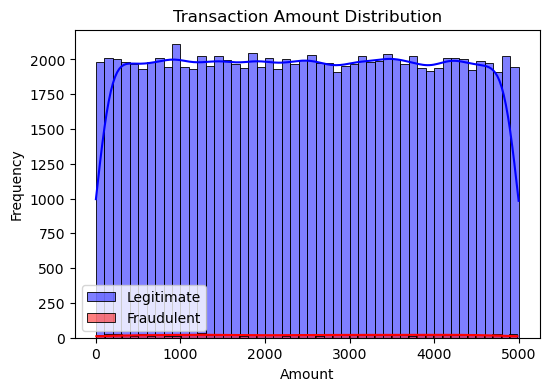

,count,mean,std,min,25%,50%,75%,max
Amount,1000.0,2517.16444,1458.643653,5.56,1249.2775,2543.43,3813.85,4985.88


In [59]:
plt.figure(figsize=(6, 4))

sns.histplot(cc_df[cc_df['IsFraud'] == 0]['Amount'], bins=50, color='blue', label='Legitimate', kde=True )
sns.histplot(cc_df[cc_df['IsFraud'] == 1]['Amount'], bins=50, color='red', label='Fraudulent', kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#mean_fraud_amt = cc_df[cc_df['IsFraud'] == 1]['Amount'].mean()
#print(f'Ave. Transaction Amount of Fraudulent Transactions: {mean_fraud_amt:.3f}')
#mean_trx_amt = cc_df[cc_df['IsFraud'] == 0]['Amount'].mean()
#print(f'Ave. Transaction Amount of Legitimate Transactions: {mean_trx_amt:.3f}')

pd.DataFrame(cc_df[cc_df['IsFraud'] == 1]['Amount'].describe()).T

The histogram illustrates the distribution of fraud across various transaction amounts, ranging from a minimum of 5.56 to a maximum of 4,985.88. 

The largest transaction amount is 2,543.43, while The middle range of values is between 1,249.28 and 3,813.85.

### Time Related Trends

In [80]:
# Reformat TransactionDate column type to datetime 
cc_df['TransactionDate'] = pd.to_datetime(cc_df['TransactionDate'])

<Figure size 600x400 with 0 Axes>

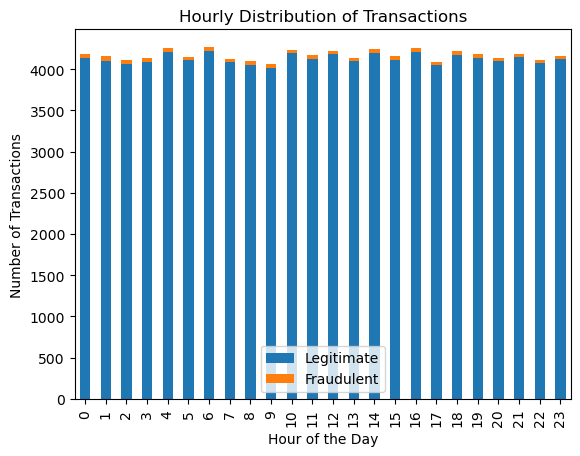

,count,mean,std,min,25%,50%,75%,max
IsFraud,,,,,,,,
0,24.0,4125.000000,57.279634,4016.0,4086.5,4120.0,4168.00,4225.0
1,24.0,41.666667,5.983068,30.0,38.0,41.5,44.25,55.0


In [89]:

# Aggregate the number of transactions every hour
trx_hours = cc_df.groupby(cc_df['TransactionDate'].dt.hour)['IsFraud'].value_counts().unstack()

# Plotting the results
plt.figure(figsize=(6, 4))
trx_hours.plot(kind='bar', stacked=True)
plt.title('Hourly Distribution of Transactions')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.legend(['Legitimate', 'Fraudulent'])
plt.show()

trx_hours.describe().T

In the transactions per hour count plot, the data displays the occurrence of fraud for each hour of the day.

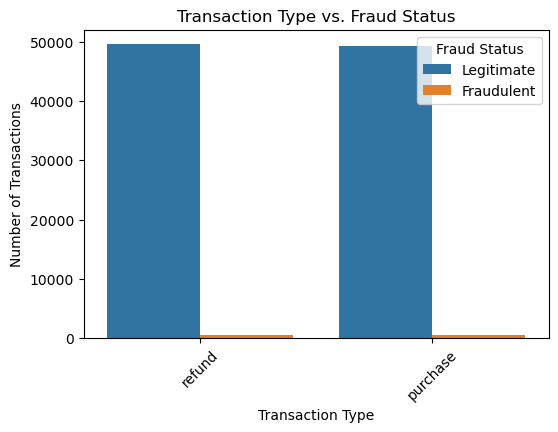

In [124]:
# Count plot for transaction types vs. fraud status
plt.figure(figsize=(6, 4))
sns.countplot(x='TransactionType', hue='IsFraud', data=cc_df)
plt.title('Transaction Type vs. Fraud Status')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend(title='Fraud Status', labels=['Legitimate', 'Fraudulent'])
plt.show()

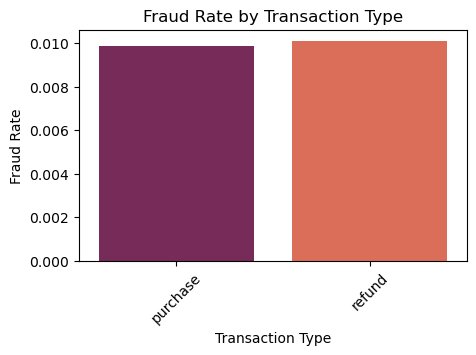

In [137]:
# Calculate fraud rate by transaction type
fraud_rate = cc_df.groupby('TransactionType')['IsFraud'].mean().reset_index()

# Rename the columns for clarity
fraud_rate.columns = ['TransactionType', 'FraudRate']

# Plotting the fraud rates
plt.figure(figsize=(5, 3))
sns.barplot(x='TransactionType', y='FraudRate', data=fraud_rate, hue='TransactionType', legend=False, palette='rocket')
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

The chart shows higher fraud rate for refund transactions.

### Trends of Fraud by Location

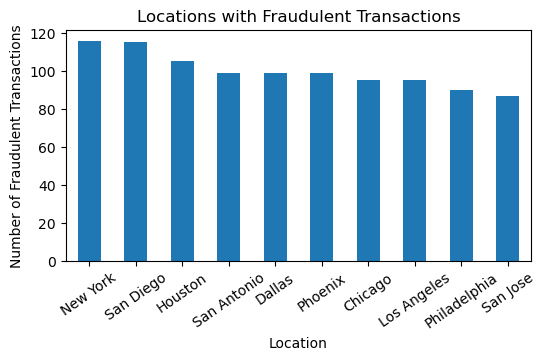

Location
New York       116
San Diego      115
Houston        105
San Antonio     99
Dallas          99
Name: count, dtype: int64

In [155]:
# Group fraudulent transactions per location
locn_frauds = cc_df[cc_df['IsFraud'] == 1]['Location'].value_counts()

# Plot locations with the highest fraud cases
plt.figure(figsize=(6, 3))
locn_frauds.plot(kind='bar')
plt.title('Locations with Fraudulent Transactions')
plt.xlabel('Location')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=35)
_ = plt.show()

locn_frauds.T[0:5,]

New York and San Diego leads with 116 and 115 fraudulent transactions. San Jose garnered the lowest frauds.

#### Explore Merchant Data

Group the data by merchant and compute statistics like the number of transactions and average transaction amounts.

No. of Merchants: 1000


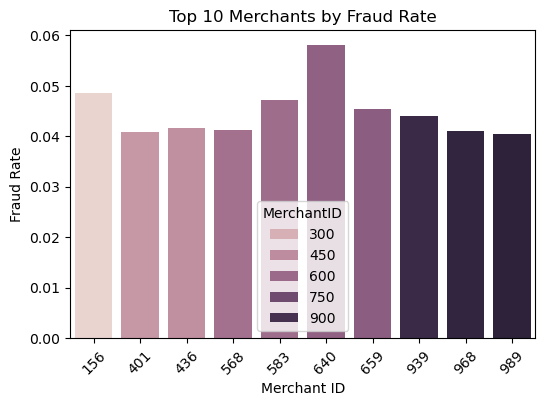

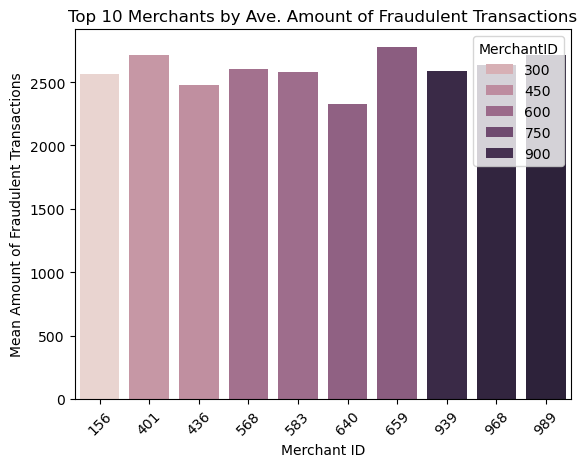

In [165]:
print(f'No. of Merchants: {len(cc_df['MerchantID'].unique())}')

# Group by MerchantID to analyze transactions
merchant_analysis = cc_df.groupby('MerchantID').agg(
    TotalTransactions=('IsFraud', 'count'),
    FraudulentTransactions=('IsFraud', 'sum'),
    AverageTransactionAmount=('Amount', 'mean')
).reset_index()

# Calculate the fraud rate for each merchant
merchant_analysis['FraudRate'] = merchant_analysis['FraudulentTransactions'] / merchant_analysis['TotalTransactions']
merchant_analysis = merchant_analysis.sort_values(by='FraudRate', ascending=False)

# Plot for the top merchants by fraud rate
plt.figure(figsize=(6, 4))
sns.barplot(x='MerchantID', y='FraudRate', hue='MerchantID', data=merchant_analysis.head(10))
plt.title('Top 10 Merchants by Fraud Rate')
plt.xlabel('Merchant ID')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

sns.barplot(x='MerchantID', y='AverageTransactionAmount', hue='MerchantID', data=merchant_analysis.head(10))
plt.title('Top 10 Merchants by Ave. Amount of Fraudulent Transactions')
plt.xlabel('Merchant ID')
plt.ylabel('Mean Amount of Fraudulent Transactions')
plt.xticks(rotation=45)

plt.show()


This bar chart visualizes the merchants with the highest fraud rates, providing an intuitive overview for stake-holders.

Merchant 640 showed the highest fraud rate, but has the lowest transaction amount.
While Merchant 659 shows the highest amount of fraudulent transaction.

### Analysis Summary

The analysis of credit card fraud data revealed significant patterns and insights from a dataset containing transaction records across various U.S. states. Key observations include:

- **Dataset Characteristics:** The dataset comprises various attributes including TransactionID, TransactionDate, Amount, MerchantID, TransactionType, Location, and IsFraud. It has no missing values and proper data types for analysis.
  
- **Fraud Distribution:** Only 10% of the transactions were identified as fraudulent, with notable trends observed in transaction amounts, types, and geographic locations. The majority of fraud occurred during refund transactions, and New York and San Diego exhibited the highest rates of fraud.

- **Feature Relationships:** Among numeric features, the transaction Amount exhibited the strongest correlation to fraud detection, though still weak. For categorical features, Location demonstrated the most significant relationship to the target variable IsFraud, highlighting its potential importance in predicting fraud.

- **Merchant Analysis:** Merchants were evaluated based on transaction volume and fraud rates. Merchant 640, despite a low transaction amount, showed a high fraud rate, whereas Merchant 659 had a higher overall fraud amount but fewer instances of fraud.

### Recommendations

1. **Real-Time Monitoring System:** Develop and implement a robust real-time monitoring system to analyze transactions as they occur, leveraging patterns identified in the analysis to flag potential fraud proactively.

2. **Enhanced Security Measures:** Increase security and verification protocols for merchants and payment providers to ensure compliance with industry regulations such as PCI-DSS, thereby minimizing risks associated with fraud.

3. **Focus on Location-Based Strategies:** Given the strong correlation between Location and fraud, implement geolocation checks and alerts to better manage high-risk areas.

4. **Merchant-Specific Strategies:** Customize fraud prevention strategies based on merchant statistics, focusing additional scrutiny on those identified with higher fraud rates, such as Merchant 640.

5. **Ongoing Training of Fraud Detection Models:** Continuously update and retrain predictive models to incorporate new transaction data, ensuring adaptive learning to changing fraud tactics.

### Conclusion

This analysis underscores the critical nature of credit card fraud detection in maintaining consumer trust and the integrity of payment systems. By employing advanced data analysis techniques, key trends and relationships have been identified, enabling targeted fraud prevention strategies. Implementing real-time monitoring and enhancing security protocols can significantly mitigate risks associated with fraudulent transactions. By understanding the factors contributing to fraud, businesses can make informed decisions to protect both their interests and those of their customers, ultimately leading to a safer and more reliable payment ecosystem.